In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.stats import spearmanr, kstest, norm

from bio_if.data.utils import FastaDataset, FixedIndexTokenizer

In [2]:
tokenizer_fn = FixedIndexTokenizer()

In [3]:
src = '../src/bio_if/data/FLIP/gb1/'
tasks = ['one_vs_rest', 'two_vs_rest', 'three_vs_rest', 'sampled']
datasets = {}
for task in tasks:
    datasets[task] = {}
    datasets[task]['train'] = FastaDataset(f'{src}/{task}.fasta', split='train', tokenizer_fn=tokenizer_fn)
    datasets[task]['val'] = FastaDataset(f'{src}/{task}.fasta', split='val', tokenizer_fn=tokenizer_fn)
    datasets[task]['test'] = FastaDataset(f'{src}/{task}.fasta', split='test', tokenizer_fn=tokenizer_fn)

In [4]:
# define an MLP
def init_regressor():
    D = 128
    return nn.Sequential(
        torch.nn.Linear(80, D),
        torch.nn.GELU(),
        torch.nn.Linear(D, D),
        torch.nn.GELU(),
        torch.nn.Linear(D, 1)
        # MLPBlock(80, D, use_relu=True),
        # MLPBlock(D, D, use_relu=True),
        # MLPBlock(D, 1, use_relu=False)
    )

In [5]:
dataloaders = {}
for task in tasks:
    dataloaders[task] = {
        'train': datasets[task]['train'].get_dataloader(batch_size=32, shuffle=True, drop_last=False),
        'val': datasets[task]['val'].get_dataloader(batch_size=32, shuffle=False, drop_last=False),
        'test': datasets[task]['test'].get_dataloader(batch_size=32, shuffle=False, drop_last=False)
    }
DEVICE = 'cuda:7'

In [6]:
def get_val_loss(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

In [7]:
def train_model(train_dataloader, val_dataloader, test_dataloader):
    EPOCHS = 10 # 00
    N_VAL_ATTEMPTS = 5
    LR = 1e-2

    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')

    val_failures = 0
    model = init_regressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1, )

    losses = []
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch in tqdm(train_dataloader):
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        val_loss = get_val_loss(model, val_dataloader, loss_fn)
        print(f'Epoch {epoch} train loss: {train_loss / len(train_dataloader)}')
        print(f'Epoch {epoch} val loss: {val_loss}')
        losses.append((train_loss / len(train_dataloader), val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            val_failures = 0
            best_model = model.state_dict()
        else:
            val_failures += 1
            if val_failures >= N_VAL_ATTEMPTS:
                print(f'Early stopping at epoch {epoch}')
                break

    model.load_state_dict(best_model)
    # make a plot of the training and validation losses
    train_losses, val_losses = zip(*losses)
    test_loss = get_val_loss(model, test_dataloader, loss_fn)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.axhline(test_loss, color='r', linestyle='--', label='test')
    plt.legend()
    return model

100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Epoch 0 train loss: 3.9286580085754395
Epoch 0 val loss: 0.7102338671684265


100%|██████████| 1/1 [00:00<00:00, 461.93it/s]


Epoch 1 train loss: 2.9987316131591797
Epoch 1 val loss: 0.3033744692802429


100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 2 train loss: 1.936808705329895
Epoch 2 val loss: 0.0940457433462143


100%|██████████| 1/1 [00:00<00:00, 560.96it/s]


Epoch 3 train loss: 0.9381899237632751
Epoch 3 val loss: 0.7465214729309082


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Epoch 4 train loss: 1.004364013671875
Epoch 4 val loss: 1.0859473943710327


100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


Epoch 5 train loss: 1.2962952852249146
Epoch 5 val loss: 0.6387355923652649


100%|██████████| 1/1 [00:00<00:00, 498.02it/s]


Epoch 6 train loss: 0.8162136673927307
Epoch 6 val loss: 0.25143787264823914


100%|██████████| 1/1 [00:00<00:00, 505.28it/s]
/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7 train loss: 0.5389655828475952
Epoch 7 val loss: 0.10447458922863007
Early stopping at epoch 7


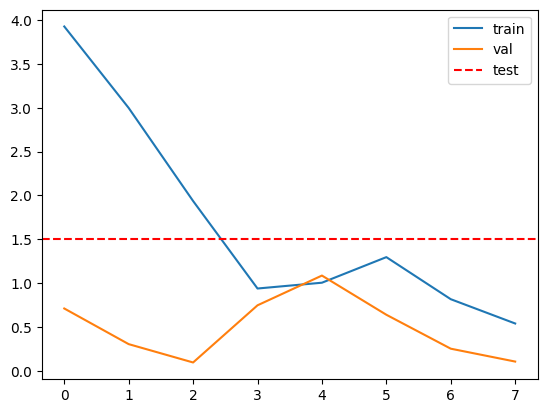

In [8]:
# train one vs rest
one_vs_rest_model = train_model(dataloaders['one_vs_rest']['train'], dataloaders['one_vs_rest']['val'], dataloaders['one_vs_rest']['test'])

100%|██████████| 12/12 [00:00<00:00, 615.93it/s]


Epoch 0 train loss: 1.1979696055253346
Epoch 0 val loss: 0.6810222268104553


100%|██████████| 12/12 [00:00<00:00, 693.07it/s]


Epoch 1 train loss: 0.5099442601203918
Epoch 1 val loss: 0.6832000017166138


100%|██████████| 12/12 [00:00<00:00, 515.59it/s]


Epoch 2 train loss: 0.35187382499376935
Epoch 2 val loss: 0.8501316010951996


100%|██████████| 12/12 [00:00<00:00, 517.80it/s]


Epoch 3 train loss: 0.28526188308993977
Epoch 3 val loss: 1.0263347029685974


100%|██████████| 12/12 [00:00<00:00, 516.64it/s]


Epoch 4 train loss: 0.2455737106502056
Epoch 4 val loss: 0.7858402729034424


100%|██████████| 12/12 [00:00<00:00, 500.37it/s]


Epoch 5 train loss: 0.19331048739453158
Epoch 5 val loss: 0.8420233130455017
Early stopping at epoch 5


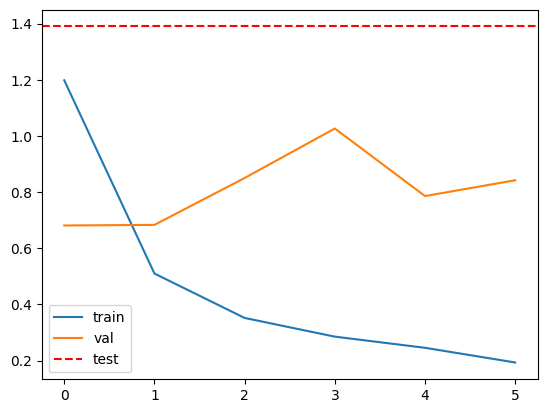

In [9]:
# train two vs rest
two_vs_rest_model = train_model(dataloaders['two_vs_rest']['train'], dataloaders['two_vs_rest']['val'], dataloaders['two_vs_rest']['test'])

100%|██████████| 85/85 [00:00<00:00, 547.02it/s]


Epoch 0 train loss: 0.8736095551182242
Epoch 0 val loss: 0.7033147633075714


100%|██████████| 85/85 [00:00<00:00, 499.69it/s]


Epoch 1 train loss: 0.61751490130144
Epoch 1 val loss: 0.5659101471304894


100%|██████████| 85/85 [00:00<00:00, 529.42it/s]


Epoch 2 train loss: 0.4194963044979993
Epoch 2 val loss: 0.39232719838619234


100%|██████████| 85/85 [00:00<00:00, 534.39it/s]


Epoch 3 train loss: 0.2929165519335691
Epoch 3 val loss: 0.3586965098977089


100%|██████████| 85/85 [00:00<00:00, 540.67it/s]


Epoch 4 train loss: 0.22252334996181375
Epoch 4 val loss: 0.28659760057926176


100%|██████████| 85/85 [00:00<00:00, 537.36it/s]


Epoch 5 train loss: 0.19288154524915357
Epoch 5 val loss: 0.2608944088220596


100%|██████████| 85/85 [00:00<00:00, 539.12it/s]


Epoch 6 train loss: 0.15492392344509853
Epoch 6 val loss: 0.22141387015581132


100%|██████████| 85/85 [00:00<00:00, 540.02it/s]


Epoch 7 train loss: 0.13683578889159595
Epoch 7 val loss: 0.22723966240882873


100%|██████████| 85/85 [00:00<00:00, 539.82it/s]


Epoch 8 train loss: 0.13179707290495143
Epoch 8 val loss: 0.21960911452770232


100%|██████████| 85/85 [00:00<00:00, 540.62it/s]


Epoch 9 train loss: 0.1266009400434354
Epoch 9 val loss: 0.2153382532298565


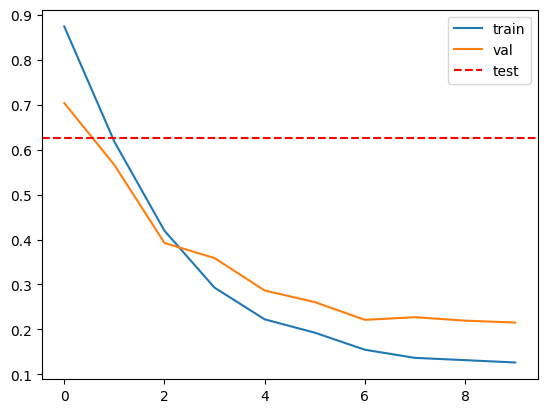

In [10]:
# train three vs rest
three_vs_rest_model = train_model(dataloaders['three_vs_rest']['train'], dataloaders['three_vs_rest']['val'], dataloaders['three_vs_rest']['test'])

100%|██████████| 197/197 [00:00<00:00, 559.00it/s]


Epoch 0 train loss: 0.7215444889619266
Epoch 0 val loss: 0.5080535635352135


100%|██████████| 197/197 [00:00<00:00, 540.01it/s]


Epoch 1 train loss: 0.3795343731638744
Epoch 1 val loss: 0.3581310188905759


100%|██████████| 197/197 [00:00<00:00, 535.45it/s]


Epoch 2 train loss: 0.2817684595052361
Epoch 2 val loss: 0.2663919200951403


100%|██████████| 197/197 [00:00<00:00, 543.35it/s]


Epoch 3 train loss: 0.20851937117915467
Epoch 3 val loss: 0.24579149078239093


100%|██████████| 197/197 [00:00<00:00, 543.42it/s]


Epoch 4 train loss: 0.19275317023399519
Epoch 4 val loss: 0.2760943975299597


100%|██████████| 197/197 [00:00<00:00, 539.48it/s]


Epoch 5 train loss: 0.18257645209352982
Epoch 5 val loss: 0.1955159396271814


100%|██████████| 197/197 [00:00<00:00, 533.17it/s]


Epoch 6 train loss: 0.1574412679422628
Epoch 6 val loss: 0.1994373161684383


100%|██████████| 197/197 [00:00<00:00, 541.01it/s]


Epoch 7 train loss: 0.16311804180596082
Epoch 7 val loss: 0.19842418571087447


100%|██████████| 197/197 [00:00<00:00, 678.56it/s]


Epoch 8 train loss: 0.1518320406262342
Epoch 8 val loss: 0.21534103832461618


100%|██████████| 197/197 [00:00<00:00, 618.04it/s]


Epoch 9 train loss: 0.1510500015908389
Epoch 9 val loss: 0.21523400032046167


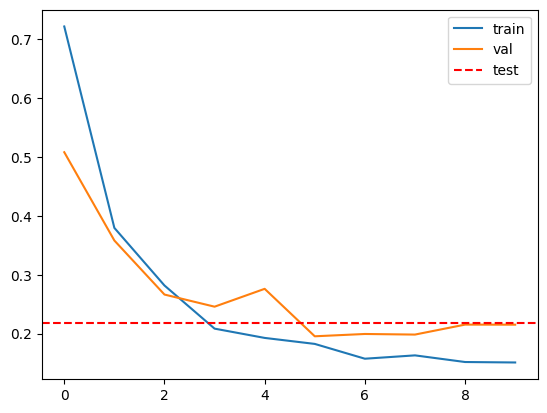

In [11]:
# train sampled
sampled_model = train_model(dataloaders['sampled']['train'], dataloaders['sampled']['val'], dataloaders['sampled']['test'])

In [12]:
def get_correlation(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, label = batch
            input_ids, label = input_ids.to(DEVICE), label.to(DEVICE)
            outputs = model(input_ids).reshape(-1)
            preds.append(outputs)
            labels.append(label)
    preds = torch.cat(preds).numpy(force=True)
    labels = torch.cat(labels).numpy(force=True)
    return spearmanr(preds, labels), preds, labels

In [13]:
# get correlations and predictions for each model on all tasks and splits
correlations = {}
predictions = {}
labels = {}
for task in tasks:
    correlations[task] = {}
    predictions[task] = {}
    labels[task] = {}
    for split in ['train', 'val', 'test']:
        correlations[task][split], predictions[task][split], labels[task][split] = get_correlation(locals()[f'{task}_model'], dataloaders[task][split])


In [14]:
# print the correlations
for task in tasks:
    for split in ['train', 'val', 'test']:
        print(f'{task} {split} spearman correlation: {correlations[task][split][0]}')

one_vs_rest train spearman correlation: 0.83
one_vs_rest val spearman correlation: 0.5
one_vs_rest test spearman correlation: 0.2524344247937046
two_vs_rest train spearman correlation: 0.8724971275244666
two_vs_rest val spearman correlation: 0.6842343702808819
two_vs_rest test spearman correlation: 0.6121019037833586
three_vs_rest train spearman correlation: 0.9424414802085238
three_vs_rest val spearman correlation: 0.9129586069379577
three_vs_rest test spearman correlation: 0.8504159978033585
sampled train spearman correlation: 0.9338314251174868
sampled val spearman correlation: 0.9194717806759548
sampled test spearman correlation: 0.9148757439729208


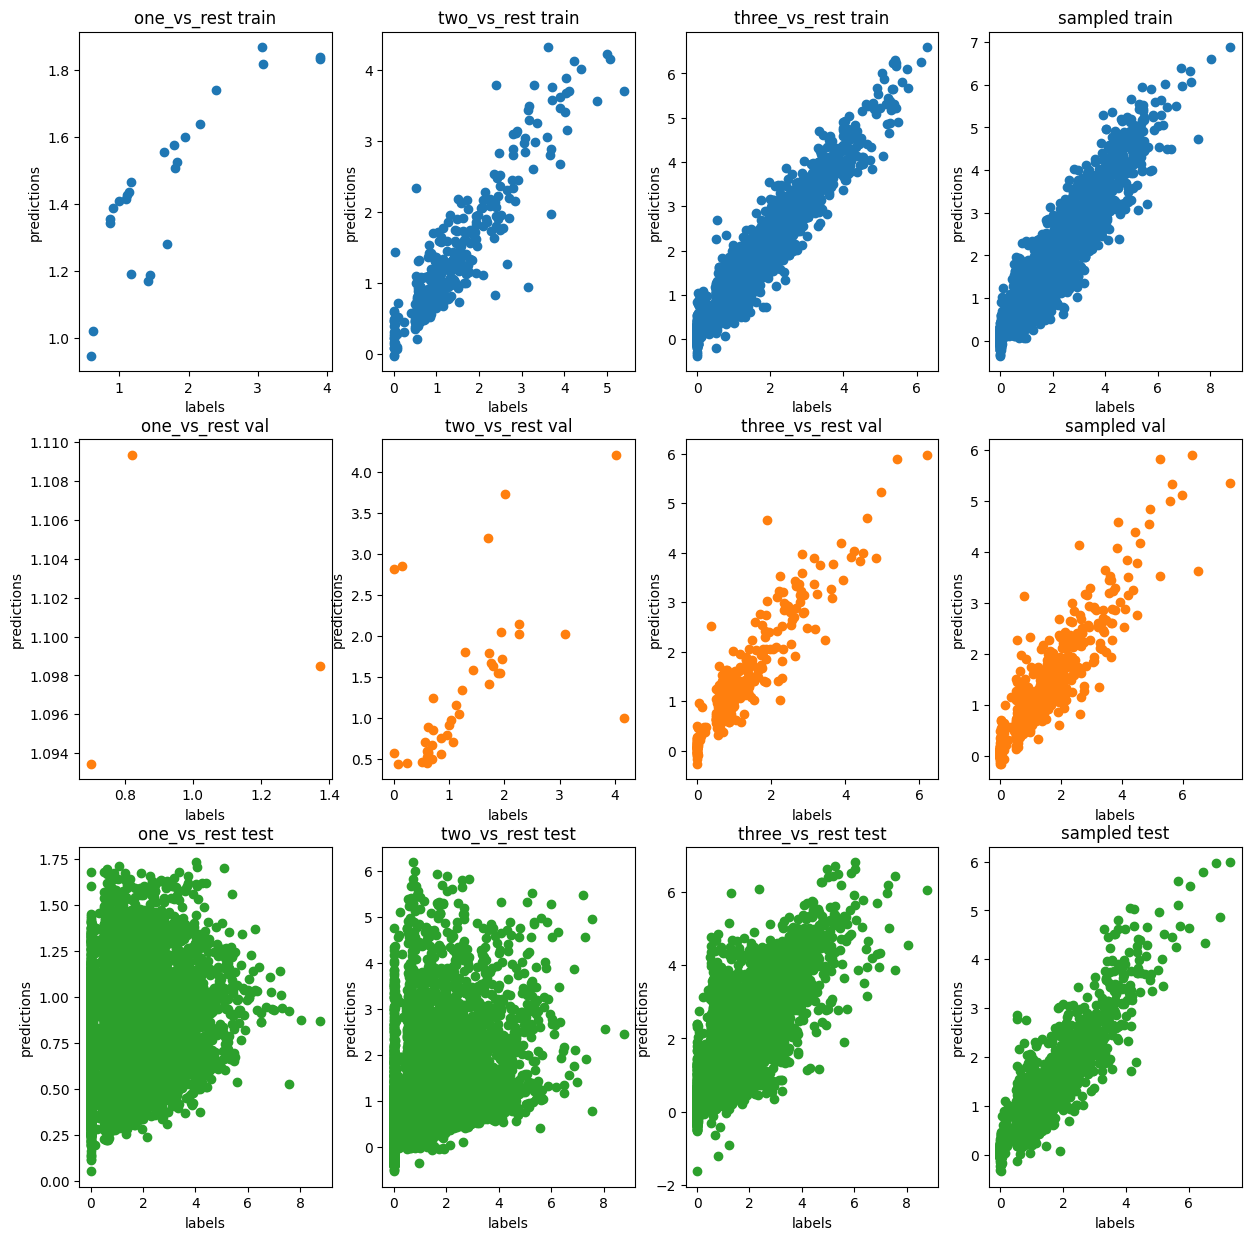

In [15]:
# make a grid of 3 rows and 4 columns with the following plots:
# each row is a split
# each column is a task
# each plot is a scatter plot of the predictions vs the labels
color = {
    'train': 'C0',
    'val': 'C1',
    'test': 'C2'
}
fig, axs = plt.subplots(3, 4, figsize=(15, 15))
for i, task in enumerate(tasks):
    for j, split in enumerate(['train', 'val', 'test']):
        
        axs[j, i].scatter(labels[task][split], predictions[task][split], color=color[split])
        axs[j, i].set_title(f'{task} {split}')
        axs[j, i].set_xlabel('labels')
        axs[j, i].set_ylabel('predictions')



In [16]:
# compute influence function of the model
from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.task import Task
from kronfluence.module.linear import TrackedLinear
import math

In [17]:
class RegressionTask(Task):
    def compute_train_loss(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, targets = batch
        outputs = model(inputs)
        if not sample:
            return F.mse_loss(outputs, targets, reduction="sum")
        with torch.no_grad():
            sampled_targets = torch.normal(outputs, std=math.sqrt(0.25)) # todo change to laplace
        return F.mse_loss(outputs, sampled_targets.detach(), reduction="sum")

    def compute_measurement(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
    ) -> torch.Tensor:
        # The measurement function is set as a training loss.
        return self.compute_train_loss(batch, model, sample=False)

In [18]:
def model_is_prepared(model):
    # return true if the model has any submodules of type TrackedLinear
    if isinstance(model, TrackedLinear):
        return True
    for submodule in model.children():
        if model_is_prepared(submodule):
            return True
    return False

In [19]:
def get_test_influence(train_dataset, test_dataset, model, task_name):
    task = RegressionTask()
    if not model_is_prepared(model):
        model = prepare_model(model=model, task=task)
    analyzer = Analyzer(
        analysis_name=f"gb1_{task_name}",
        model=model,
        task=task,
    ) 
    analyzer.fit_all_factors(factors_name="all_factors", dataset=train_dataset)
    analyzer.compute_pairwise_scores(
        scores_name="pairwise_scores",
        factors_name="all_factors",
        train_dataset=train_dataset,
        query_dataset=test_dataset,
        per_device_query_batch_size=32,
    )
    return analyzer.load_pairwise_scores(scores_name="pairwise_scores")

In [20]:
influences = {}
for task in tasks:
    print(f'Computing influence for {task}')
    influences[task] = get_test_influence(datasets[task]['train'], datasets[task]['test'], locals()[f'{task}_model'], task)

Computing influence for one_vs_rest
Computing influence for two_vs_rest
Computing influence for three_vs_rest
Computing influence for sampled


In [21]:
# save all models and influences to a folder stamped with the date and time
import os
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
os.makedirs(f'cached_runs/gb1/{now}', exist_ok=True)
# save the models state dicts and influences
torch.save(one_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/one_vs_rest_model.pt')
torch.save(two_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/two_vs_rest_model.pt')
torch.save(three_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/three_vs_rest_model.pt')
torch.save(sampled_model.state_dict(), f'cached_runs/gb1/{now}/sampled_model.pt')
torch.save(influences, f'cached_runs/gb1/{now}/influences.pt')

In [22]:
# load the influences
version = "2024-03-11_19-59-26"
influences = torch.load(f'cached_runs/gb1/{version}/influences.pt')

In [23]:
# load the models
one_vs_rest_model = init_regressor()
one_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/one_vs_rest_model.pt'))
two_vs_rest_model = init_regressor()
two_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/two_vs_rest_model.pt'))
three_vs_rest_model = init_regressor()
three_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/three_vs_rest_model.pt'))
sampled_model = init_regressor()
sampled_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/sampled_model.pt'))
one_vs_rest_model.to(DEVICE)
two_vs_rest_model.to(DEVICE)
three_vs_rest_model.to(DEVICE)
sampled_model.to(DEVICE)

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.weight", "0.bias", "2.weight", "2.bias", "4.weight", "4.bias". 
	Unexpected key(s) in state_dict: "0.linear.weight", "0.linear.bias", "1.linear.weight", "1.linear.bias", "2.linear.weight", "2.linear.bias". 

In [ ]:
for task in influences:
    influences[task] = influences[task]['all_modules'].mean(dim=0)    

In [ ]:
influences

{'one_vs_rest': tensor([-7.2171e+03,  1.7729e+04,  3.2273e+04,  1.3840e+03,  3.7821e+01,
          7.9288e+01,  1.3723e+03,  1.5529e+04,  4.2609e+04,  3.5006e+03,
         -1.2461e+03,  5.9901e+03,  6.5730e+02,  7.5666e+02,  3.1038e+03,
          5.7334e+03,  1.8812e+03,  1.5259e+02,  7.4286e+02,  4.8945e+02,
          1.2880e+02, -1.3094e+02,  3.9084e+02, -5.6662e+03, -1.8873e+03]),
 'two_vs_rest': tensor([ 4.4838e+05, -7.7454e+05, -8.7571e+05, -1.7415e+06, -6.2646e+05,
          1.3715e+05,  4.5049e+05,  1.9642e+05,  1.4115e+05,  3.2187e+05,
         -7.4062e+05, -2.3333e+06, -7.2305e+05, -5.2654e+06, -2.2866e+06,
         -5.6273e+06,  1.6212e+05,  7.3733e+04, -1.0396e+06, -4.0790e+05,
         -5.9837e+05, -2.5011e+05, -6.5506e+05, -1.2392e+05, -3.1532e+05,
         -6.2696e+06, -7.0716e+06,  1.9075e+06,  2.2345e+06,  2.4229e+06,
          3.9353e+04,  1.7304e+05,  4.4269e+05,  1.7321e+05,  2.5387e+06,
          1.7119e+06,  1.0538e+06, -2.6320e+05,  1.3219e+06,  3.2339e+05,
      

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

In [ ]:
def compute_alpha(influences):
    # sort influences and take top 1 percent
    influences_sorted = torch.sort(influences).values.numpy(force=True)
    n = len(influences_sorted)
    top_1_percent = influences_sorted[int(n * 0.99):]
    n_top_1 = len(top_1_percent)
    # cdf: y = 1 - (x / x_min) ** -alpha
    # 1-y = (x / x_min) ** -alpha
    # log(1-y) = -alpha * log(x / x_min)
    # fit a power law to the top 1 percent
    # fit ridge regression to the above equation
    log_y = np.log(1-np.linspace(0.99, 1, n_top_1, endpoint=False))
    log_y_mean = log_y.mean()
    log_x = np.log(top_1_percent) - np.log(top_1_percent.min())
    log_x_mean = log_x.mean()
    alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
    return alpha

In [ ]:
def plot_comp_cdf(influences, ax):
    influences_sorted = torch.sort(influences).values.numpy(force=True)
    n = len(influences)
    top_1_percent = influences_sorted[int(n * 0.99):]
    alpha = compute_alpha(influences)
    complementary_cdf = 1-np.linspace(0, 1, n, endpoint=False)
    # plot a power law to the top 1 percent
    m = top_1_percent[0]
    v = np.exp(np.log(0.01)-alpha * (np.log(top_1_percent[-1]/m) - np.log(top_1_percent[0]/m)))
    if not np.isnan(alpha):
        ax.plot((top_1_percent[0], top_1_percent[-1]), (0.01, v), label=f'α={alpha:.2f}', linestyle='--', linewidth=3, zorder=10)
    # sns.lineplot([top_1_percent[0], top_1_percent[-1]], [0.01, 0], label='Power Law Fit')

    # plot a CDF of the influences
    ax.plot(influences_sorted, complementary_cdf, linewidth=3, color='C1')
    ax.set_xlabel('Influence')
    ax.set_ylabel('1-CDF')
    # make the plot log-log
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(1e-3, 1)
    if not np.isnan(alpha):
        ax.legend()

/tmp/ipykernel_129720/4018897033.py:16: RuntimeWarning: invalid value encountered in scalar divide
  alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)


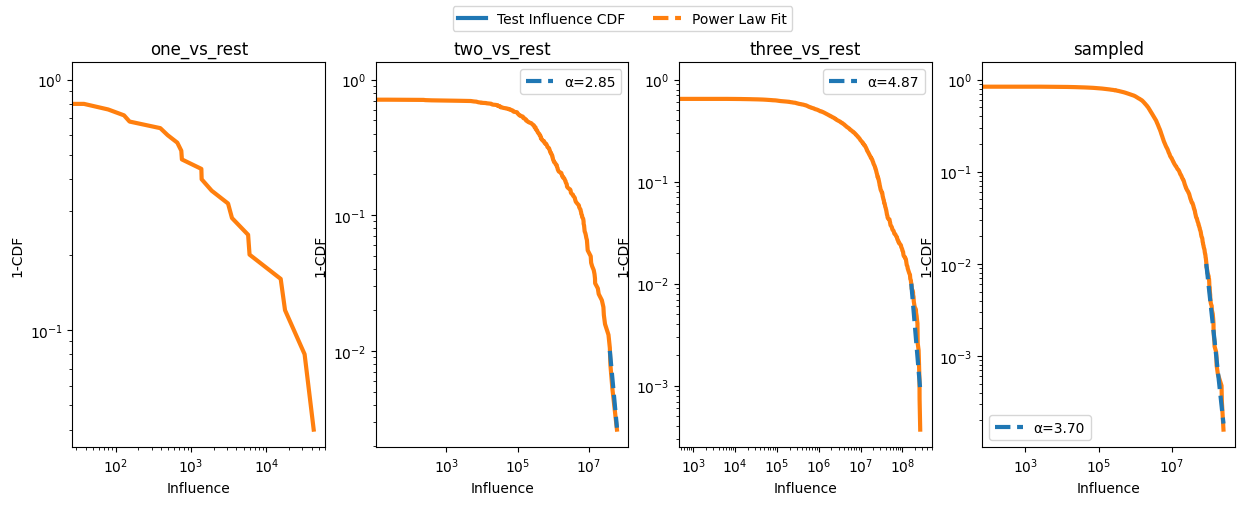

In [ ]:
# plot the complementary CDF of the influences in a log-log plot for each of the tasks
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, task in enumerate(tasks):
    plot_comp_cdf(influences[task], axs[i])
    axs[i].set_title(task)
# add a legend to the whole plot
custom_lines = [Line2D([0], [0], color='C0', lw=3),
                Line2D([0], [0], color='C1', lw=3, linestyle='--')]
fig.legend(custom_lines, ['Test Influence CDF', 'Power Law Fit'], loc='upper center', ncol=2)